## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Business Understanding

- Predictive sale pricing for relators working with sellers (price the home to sell)

### Problem/Stakeholder
We are a data science consulting company working with  

### Data Understanding

## Data Preparation

In [433]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

Pulling in data and exploring data prior to cleaning.

In [434]:
data = pd.read_csv('./data/kc_house_data.csv')

In [435]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [436]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [437]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We see nulls in "waterfront", "view", and "yr_renovated" columns. 

In [438]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


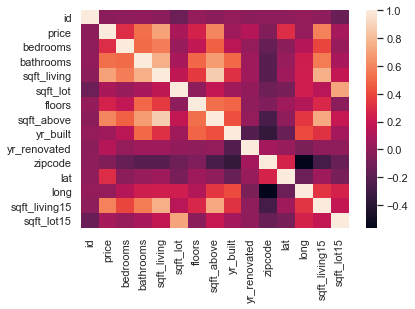

In [439]:
sns.heatmap(data.corr());

In [440]:
#Yr_renovated and price correlation .1296; might flatten past a certain year.  

In [441]:
data.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We see we have both nulls and "0" values in this column.

In [442]:
data.yr_renovated.describe()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [443]:
17755 - 17011

744

In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [445]:
data.drop(columns='yr_renovated', inplace=True)

Dropping the column 'yr_renovated' due to the low value counts.

In [446]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [447]:
data.waterfront.value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [448]:
data.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Only 60 null values, could drop those rows utilizing dropna or replace with our Mode value, "None."

In [449]:
data['view'].fillna("NONE", inplace=True)

In [450]:
data['view'].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [451]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [452]:
data['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

No is overwhelming mode; could replace nulls with mode or create 3rd column "Unknown". 

In [453]:
data['waterfront'].fillna("UNKNOWN", inplace=True)

In [454]:
data['waterfront'].value_counts()

NO         19075
UNKNOWN     2376
YES          146
Name: waterfront, dtype: int64

In [455]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [456]:
data['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1548.0        1
2500.0        1
2400.0        1
588.0         1
861.0         1
Name: sqft_basement, Length: 304, dtype: int64

Here we see we have some values of "?"; we need to decide how to clean this data. We will replace "?" with 0 because a large proportion of our data is at 0.

In [457]:
data['sqft_basement'].replace(to_replace = '?', value = 0.0, inplace=True)

In [458]:
data['sqft_basement'].value_counts()

0.0       12826
0.0         454
600.0       217
500.0       209
700.0       208
          ...  
2360.0        1
3260.0        1
3480.0        1
176.0         1
2850.0        1
Name: sqft_basement, Length: 304, dtype: int64

Adding price per sqft columnn to help with comparison.

In [459]:
data['price_per_sqft_living'] = (data['price']/data['sqft_living'])

In [460]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,7 Average,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,188.050847
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,209.338521
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,98028,47.7379,-122.233,2720,8062,233.766234
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,308.163265
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,303.571429


We want to further look into how distance from the epicenter of Seattle effects sale price. We will create a column calculating difference between home and Seattle epicenter. We will be utilizing the Seattle Art Museum coordinates for Seattle: (lat = 47.6077, long= -122.337).

In [461]:
from geopy.distance import geodesic
import geopy

In [462]:
print(geodesic((47.5112, -122.257), (47.6077, -122.337)).miles)

7.644653496774576


In [463]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,7 Average,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,188.050847
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,209.338521
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,98028,47.7379,-122.233,2720,8062,233.766234
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,308.163265
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,303.571429


In [464]:
coords = (47.6077, -122.337)

In [465]:
data['distance_from_Seattle'] = data.apply(lambda x: geopy.distance.distance((x.lat, x. long), coords).miles, axis=1)

In [466]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,distance_from_Seattle
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,188.050847,7.644653
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,209.338521,7.872439
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,98028,47.7379,-122.233,2720,8062,233.766234,10.220653
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,308.163265,6.549707
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,303.571429,13.655673


We have cleaned all of our null values. 

In [467]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,distance_from_Seattle
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.005244,0.005637
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,-0.053402,0.306692,0.022036,0.585241,0.082845,0.556056,-0.283695
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.205905,0.060389
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,-0.204786,0.024280,0.224903,0.569884,0.088303,-0.090285,0.085972
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,-0.199802,0.052155,0.241214,0.756402,0.184342,-0.091167,0.078156
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.034749,0.243417
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.004651,0.004185
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,-0.261570,-0.001199,0.344842,0.731767,0.195077,-0.087555,0.194562
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.347210,-0.148370,0.409993,0.326377,0.070777,-0.290041,0.391457
zipcode,-0.008211,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,-0.347210,1.000000,0.266742,-0.564259,-0.279299,-0.147294,0.172752,-0.526242


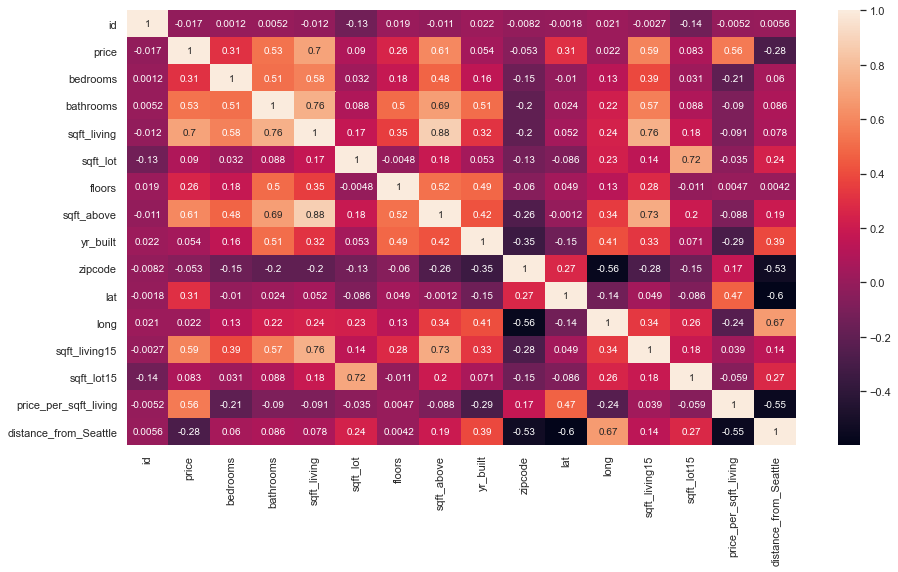

In [468]:
cor = data.corr()

plt.figure(figsize = (15, 8))
sns.heatmap(cor, annot=True);

We see that there is a large difference in the correlations between codition and price and grade and price, even though the columns seem to describe similar attributes. 

- 'sqft_living' highly correlated to 'bathrooms', 'grade', 'sqft_above', and 'sqft_living15'
- 'sqft_lot' is highly correlated to 'sqft_lot15'

Starting with our simple model, we will look at the model utilizing sqft_living as our independent variable based on it having the highest correlation with price.

In [469]:
simple_formula = 'price ~ sqft_living'
simple_mod = ols(formula=simple_formula, data=data).fit()

In [470]:
simple_mod_summ = simple_mod.summary()

In [471]:
simple_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:22:23   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For our simple summary, we see an R-squared of .493. Our p-value is <.05, showing that our results are statistically repeatable. 

In [472]:
## Other regressions prior to fitting that checked variables with high correlation to price

In [473]:
formula = 'price ~ bedrooms + sqft_living + sqft_lot + floors + condition + yr_built + zipcode + lat + long'
mod = ols(formula=formula, data=data).fit()
mod_summ = mod.summary()

In [474]:
mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     2840.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:22:24   Log-Likelihood:            -2.9716e+05
No. Observations:               21597   AIC:                         5.943e+05
Df Residuals:                   21584   BIC:                         5.945e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -6.961e+05   3.21e+06     -0.217      0.829      -7e+06    5.61e+06
condition[T.Fair]      -1.827e+04   1.78e+04     -1.026      0.305   -5.32e+04    1.66e+04
condition[T.Good]       2.172e+04   3920.360      5.540      0.000     1.4e+04    2.94e+04
condition[T.Poor]      -4.567e+04   4.27e+04     -1.071      0.284   -1.29e+05    3.79e+04
condition[T.Very Good]  5.829e+04   6224.478      9.365      0.000    4.61e+04    7.05e+04
bedrooms               -5.755e+04   2080.456    -27.660      0.000   -6.16e+04   -5.35e+04
sqft_living              321.7969      2.291    140.463      0.000     317.306     326.287
sqft_lot                  -0.0047      0.039     -0.119      0.905      -0.082       0.073
floors                  5.438e+04   3513.896     15.476      0.000    4.75e+04    6.13e+04
yr_built               -1881.3748     72.547    -25.933      0.000   -2023.572   -1739.178
zipcode                 -650.3949     37.263    -17.454      0.000    -723.434    -577.356
lat                     6.546e+05   1.19e+04     54.971      0.000    6.31e+05    6.78e+05
long                    -3.03e+05   1.43e+04    -21.198      0.000   -3.31e+05   -2.75e+05
==============================================================================
Omnibus:                    16367.326   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           868711.384
Skew:                           3.158   Prob(JB):                         0.00
Kurtosis:                      33.422   Cond. No.                     2.05e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see a very high p-value with sqft_lot. We also see a very high cond. no. suggesting strong multicollinearity or other problems. We need to scale our data. How to improve our regression:
- Scaling
- Improving multicollinearity issues/ lowering cond. no.
- Skew seems high
- May be working with too many variables

In [475]:
formula2 = 'price ~ sqft_living + floors + bedrooms '
mod2 = ols(formula=formula2, data=data).fit()
mod_summ2 = mod2.summary()

In [476]:
mod_summ2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     7398.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:22:24   Log-Likelihood:            -2.9976e+05
No. Observations:               21597   AIC:                         5.995e+05
Df Residuals:                   21593   BIC:                         5.996e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.704e+04   7684.108     10.026      0.000     6.2e+04    9.21e+04
sqft_living   313.8304      2.467    127.187      0.000     308.994     318.667
floors       3476.4322   3480.340      0.999      0.318   -3345.290    1.03e+04
bedrooms    -5.775e+04   2324.412    -24.846      0.000   -6.23e+04   -5.32e+04
==============================================================================
Omnibus:                    14415.709   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           491526.502
Skew:                           2.733   Prob(JB):                         0.00
Kurtosis:                      25.723   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using fewer variables we see a decrease in both our R-squared and our Cond. No.

In [477]:
formula3 = 'price ~ grade + bathrooms + bedrooms '
mod3 = ols(formula=formula3, data=data).fit()
mod_summ3 = mod3.summary()

In [478]:
mod_summ3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2085.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:22:24   Log-Likelihood:            -2.9908e+05
No. Observations:               21597   AIC:                         5.982e+05
Df Residuals:                   21584   BIC:                         5.983e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 7.9e+05   1.25e+04     63.103      0.000    7.65e+05    8.15e+05
grade[T.11 Excellent]   3.883e+05   1.46e+04     26.535      0.000     3.6e+05    4.17e+05
grade[T.12 Luxury]      1.057e+06   2.77e+04     38.174      0.000       1e+06    1.11e+06
grade[T.13 Mansion]     2.485e+06      7e+04     35.476      0.000    2.35e+06    2.62e+06
grade[T.3 Poor]         -5.99e+05    2.5e+05     -2.393      0.017   -1.09e+06   -1.08e+05
grade[T.4 Low]         -6.731e+05   4.92e+04    -13.694      0.000   -7.69e+05   -5.77e+05
grade[T.5 Fair]        -6.685e+05   1.86e+04    -35.923      0.000   -7.05e+05   -6.32e+05
grade[T.6 Low Average] -6.304e+05   1.07e+04    -59.096      0.000   -6.51e+05    -6.1e+05
grade[T.7 Average]     -5.803e+05   8633.133    -67.217      0.000   -5.97e+05   -5.63e+05
grade[T.8 Good]        -4.779e+05   8326.815    -57.388      0.000   -4.94e+05   -4.62e+05
grade[T.9 Better]      -2.739e+05   8951.735    -30.598      0.000   -2.91e+05   -2.56e+05
bathrooms               6.285e+04   3260.678     19.274      0.000    5.65e+04    6.92e+04
bedrooms                2.391e+04   2156.155     11.091      0.000    1.97e+04    2.81e+04
==============================================================================
Omnibus:                    15476.194   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           738153.954
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      31.037   Cond. No.                         627.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Our R-squared number decreased, but our Cond. No. also decreased substantially by not using sqft as a variable. Sqft seems to have most multicollinearity issues. Our skew here is high.

We need to decide how to deal with our categorical variables.

In [479]:
data['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [480]:
data['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [481]:
data['condition'] = pd.Categorical(data['condition'], ['Poor','Fair','Average','Good', 'Very Good'])

Here, we create visualizations to see if the data is relatively normal and if we want to utilize the data. If we decide to utilize these variables and hot code, we need to drop a column to prevent multicollinearity. Column dropped becomes baseline. View article link: https://github.com/hoffm386/coefficients-of-dropped-categorical-variables 


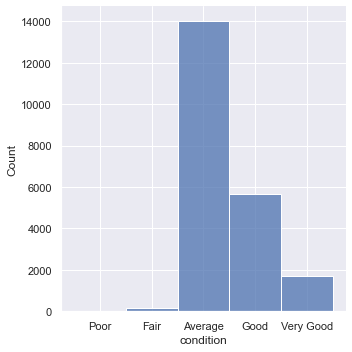

In [482]:
sns.displot(data=data, x='condition');

In [483]:
data['grade'] = pd.Categorical(data['grade'], ['3 Poor','4 Low','5 Fair','6 Low Average', '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion'])

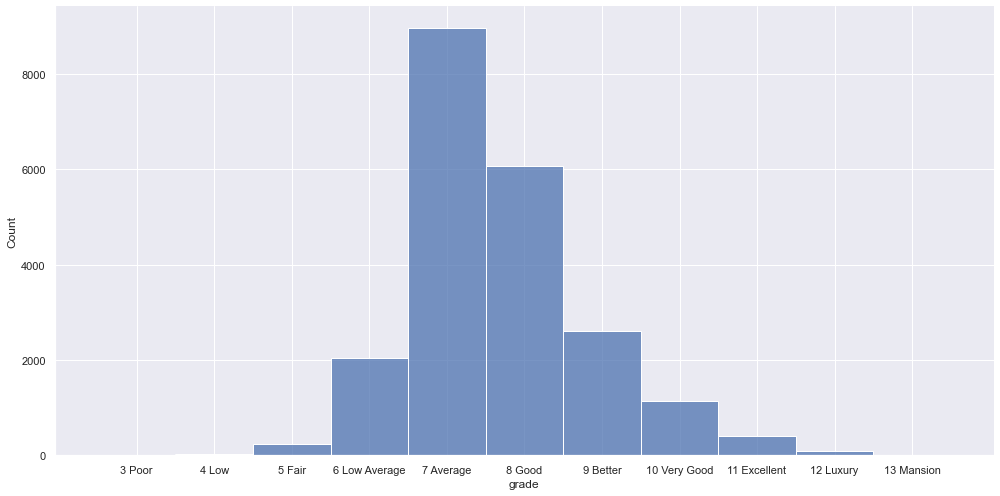

In [484]:
sns.displot(data=data, x='grade', height=7, aspect=2);

- Normalish distribution, when modeling we will drop the "grade_ 7 Average" column to utilize Average as the baseline.

In [485]:
data_dummy_condition = pd.get_dummies(data, columns=['condition'])

In [486]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,distance_from_Seattle
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,188.050847,7.644653
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,209.338521,7.872439
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,98028,47.7379,-122.233,2720,8062,233.766234,10.220653
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,308.163265,6.549707
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,303.571429,13.655673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,0.0,2009,98103,47.6993,-122.346,1530,1509,235.294118,6.342232
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,0.0,2014,98146,47.5107,-122.362,1830,7200,173.160173,6.802472
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,0.0,2009,98144,47.5944,-122.299,1020,2007,394.216667,1.999258
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,UNKNOWN,NONE,...,1600,0.0,2004,98027,47.5345,-122.069,1410,1287,250.000000,13.511845


In [487]:
data_dummy_grade= pd.get_dummies(data, columns=['grade'])

In [488]:
data_dummy_grade

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,0,0,0,1,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0,0,1,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,UNKNOWN,NONE,...,0,0,0,0,1,0,0,0,0,0


Data needs to be scaled because units are not the same; scaling for One Hot depends on what kind of scaling we are utilizing. Standard scaling could potentially scale everything (including One Hot).

In [489]:
data.drop(columns=('id'), inplace=True)

In [490]:
data.drop(columns=('date'), inplace=True)

Dropping ID and date columns because they do not contain data important to our analysis.

In [491]:
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,distance_from_Seattle
0,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,Average,7 Average,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,188.050847,7.644653
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,209.338521,7.872439
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,98028,47.7379,-122.233,2720,8062,233.766234,10.220653
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,308.163265,6.549707
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,303.571429,13.655673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,98103,47.6993,-122.346,1530,1509,235.294118,6.342232
21593,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,98146,47.5107,-122.362,1830,7200,173.160173,6.802472
21594,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,98144,47.5944,-122.299,1020,2007,394.216667,1.999258
21595,400000.0,3,2.50,1600,2388,2.0,UNKNOWN,NONE,Average,8 Good,1600,0.0,2004,98027,47.5345,-122.069,1410,1287,250.000000,13.511845


In [492]:
data.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft_living,distance_from_Seattle
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,-0.053402,0.306692,0.022036,0.585241,0.082845,0.556056,-0.283695
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.205905,0.060389
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,-0.204786,0.024280,0.224903,0.569884,0.088303,-0.090285,0.085972
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,-0.199802,0.052155,0.241214,0.756402,0.184342,-0.091167,0.078156
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.034749,0.243417
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.004651,0.004185
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,-0.261570,-0.001199,0.344842,0.731767,0.195077,-0.087555,0.194562
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.347210,-0.148370,0.409993,0.326377,0.070777,-0.290041,0.391457
zipcode,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,-0.347210,1.000000,0.266742,-0.564259,-0.279299,-0.147294,0.172752,-0.526242
lat,0.306692,-0.009951,0.024280,0.052155,-0.085514,0.049239,-0.001199,-0.148370,0.266742,1.000000,-0.135371,0.048679,-0.086139,0.472516,-0.598695


In [493]:
data_dummy_grade

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,UNKNOWN,NONE,...,0,0,0,1,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0,0,1,0,0,0,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0,0,0,0,1,0,0,0,0,0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0,0,0,1,0,0,0,0,0,0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,UNKNOWN,NONE,...,0,0,0,0,1,0,0,0,0,0


In [494]:
data_dummy_grade.drop(columns=('id'), inplace=True)

In [495]:
data_dummy_grade.drop(columns=('date'), inplace=True)

In [496]:
data_dummy_grade.drop(columns=('waterfront'), inplace=True)

In [497]:
data_dummy_grade.drop(columns=('view'), inplace=True)

In [498]:
data_dummy_grade.drop(columns=('condition'), inplace=True)

In [499]:
data_dummy_grade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21597 non-null  float64
 1   bedrooms               21597 non-null  int64  
 2   bathrooms              21597 non-null  float64
 3   sqft_living            21597 non-null  int64  
 4   sqft_lot               21597 non-null  int64  
 5   floors                 21597 non-null  float64
 6   sqft_above             21597 non-null  int64  
 7   sqft_basement          21597 non-null  object 
 8   yr_built               21597 non-null  int64  
 9   zipcode                21597 non-null  int64  
 10  lat                    21597 non-null  float64
 11  long                   21597 non-null  float64
 12  sqft_living15          21597 non-null  int64  
 13  sqft_lot15             21597 non-null  int64  
 14  price_per_sqft_living  21597 non-null  float64
 15  di

In [500]:
ss = StandardScaler()
ss.fit(data_dummy_grade)
data_dummy_grade_scaled = ss.transform(data_dummy_grade)

In [501]:
data_dummy_grade_scaled

array([[-0.86671627, -0.40290302, -1.45107268, ..., -0.13719523,
        -0.06432725, -0.02454176],
       [-0.00625157, -0.40290302,  0.17448579, ..., -0.13719523,
        -0.06432725, -0.02454176],
       [-0.98077344, -1.48249316, -1.45107268, ..., -0.13719523,
        -0.06432725, -0.02454176],
       ...,
       [-0.37618606, -1.48249316, -1.77618438, ..., -0.13719523,
        -0.06432725, -0.02454176],
       [-0.38190525, -0.40290302,  0.49959749, ..., -0.13719523,
        -0.06432725, -0.02454176],
       [-0.58606486, -1.48249316, -1.77618438, ..., -0.13719523,
        -0.06432725, -0.02454176]])

In [502]:
df_scaled = pd.DataFrame(ss.fit_transform(data_dummy_grade),columns = data_dummy_grade.columns)

In [503]:
df_scaled

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,zipcode,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion
0,-0.866716,-0.402903,-1.451073,-0.980652,-0.228182,-0.915552,-0.735251,-0.649637,-0.544678,1.869645,...,-0.03538,-0.106453,-0.322796,1.186010,-0.624887,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
1,-0.006252,-0.402903,0.174486,0.533369,-0.189739,0.937431,0.460776,0.259847,-0.680850,0.879210,...,-0.03538,-0.106453,-0.322796,1.186010,-0.624887,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
2,-0.980773,-1.482493,-1.451073,-1.427234,-0.123139,-0.915552,-1.230575,-0.649637,-1.293626,-0.933473,...,-0.03538,-0.106453,3.097927,-0.843163,-0.624887,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
3,0.173409,0.676687,1.149821,-0.131057,-0.243878,-0.915552,-0.892305,1.419440,-0.204247,1.084772,...,-0.03538,-0.106453,-0.322796,1.186010,-0.624887,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
4,-0.082471,-0.402903,-0.150626,-0.436040,-0.169503,-0.915552,-0.131197,-0.649637,0.544700,-0.073850,...,-0.03538,-0.106453,-0.322796,-0.843163,1.600289,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,-0.490790,-0.402903,0.499597,-0.599424,-0.337306,2.790414,-0.312413,-0.649637,1.293648,0.468086,...,-0.03538,-0.106453,-0.322796,-0.843163,1.600289,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
21593,-0.381905,0.676687,0.499597,0.250171,-0.224246,0.937431,0.629911,-0.649637,1.463863,1.271647,...,-0.03538,-0.106453,-0.322796,-0.843163,1.600289,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
21594,-0.376186,-1.482493,-1.776184,-1.154928,-0.332018,0.937431,-0.928548,-0.649637,1.293648,1.234272,...,-0.03538,-0.106453,-0.322796,1.186010,-0.624887,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542
21595,-0.381905,-0.402903,0.499597,-0.523178,-0.306952,0.937431,-0.227845,-0.649637,1.123432,-0.952160,...,-0.03538,-0.106453,-0.322796,-0.843163,1.600289,-0.371163,-0.235408,-0.137195,-0.064327,-0.024542


In [504]:
df_scaled.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,zipcode,...,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.321108,0.053953,-0.053402,...,-0.031618,-0.084549,-0.209463,-0.316053,0.004576,0.235859,0.340944,0.357589,0.291068,0.211806
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.297229,0.155670,-0.154092,...,-0.068012,-0.113175,-0.239492,-0.104791,0.073140,0.160294,0.135766,0.116596,0.062257,0.039026
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.278485,0.507173,-0.204786,...,-0.055599,-0.138740,-0.366185,-0.313457,0.189426,0.264756,0.272635,0.247293,0.159734,0.095118
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.428660,0.318152,-0.199802,...,-0.053935,-0.127198,-0.312486,-0.358915,0.071115,0.318499,0.369228,0.345964,0.238136,0.144424
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.015031,0.052946,-0.129586,...,0.000440,0.022931,-0.019116,-0.067791,-0.023923,0.049646,0.074421,0.077104,0.061699,0.007767
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,-0.241866,0.489193,-0.059541,...,-0.029964,-0.080346,-0.230529,-0.308247,0.201188,0.244184,0.173943,0.118735,0.054276,0.021257
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,-0.051175,0.424037,-0.261570,...,-0.047669,-0.108543,-0.280761,-0.387255,0.059423,0.343388,0.376399,0.342198,0.222177,0.126666
sqft_basement,0.321108,0.297229,0.278485,0.428660,0.015031,-0.241866,-0.051175,1.000000,-0.130085,0.073271,...,-0.022388,-0.059784,-0.120907,-0.019855,0.035518,0.017906,0.060511,0.076299,0.079831,0.063423
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,-0.130085,1.000000,-0.347210,...,-0.041843,-0.128815,-0.313501,-0.211966,0.199844,0.220104,0.148820,0.098762,0.046874,0.004692
zipcode,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,0.073271,-0.347210,1.000000,...,-0.006163,0.009434,0.148832,0.070285,-0.052619,-0.087750,-0.073251,-0.058189,-0.039301,0.003762


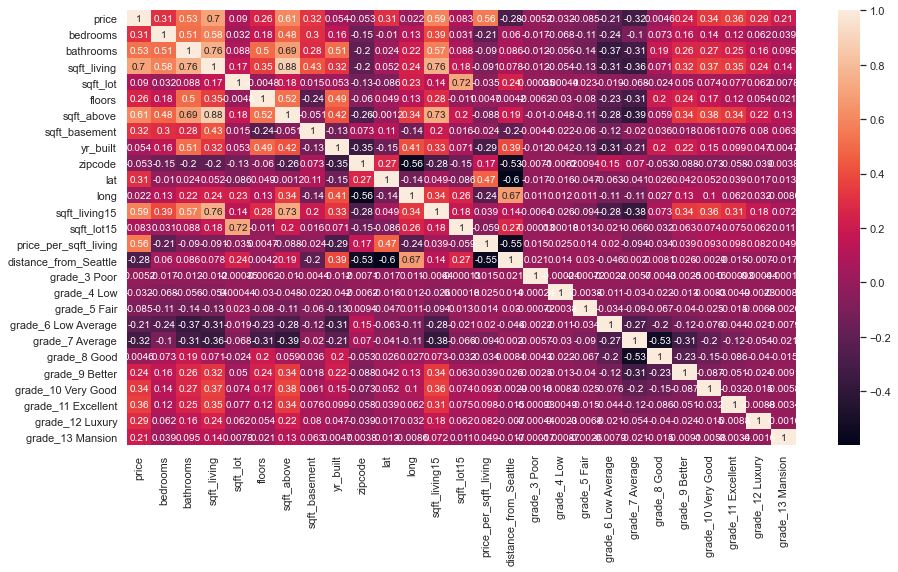

In [505]:
cor = df_scaled.corr()

plt.figure(figsize = (15, 8))
sns.heatmap(cor, annot=True);